## Example of Trans-C sampling across independent model states

This notebook demonstrates sampling across unormalized multi-dimensional Gaussian PDFs in states with non-consequtive dimensions
using the Product-Space sampler.

In [1]:
# general python utility packages
import time
from collections import Counter
from functools import partial

import corner
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

#### TransC class

In [2]:
from pytransc.analysis.samples import get_transc_samples
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_product_space_sampler, run_mcmc_per_state
from pytransc.samplers.product_space import ProductSpace
from pytransc.utils.auto_pseudo import PseudoPriorBuilders, build_auto_pseudo_prior

In [3]:
def flatten_extend(matrix):
    """Flatten a 2D matrix into a 1D numpy array."""
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

--------

## Example set up: Three states with non-consecutive dimensions, 3D, 5D and 10D Gaussians

Set some global control parameters for all examples.

In [4]:
plotting = True  # Create some diagnostic displays of outputs
parallel = False  # Use parallel computation for sampling
autopseudo = True  # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False  # Thin internally generated within state posterior ensembles by their auto-correlation
# (This can take additional compute time, and is not necessary if input ensembles are already independent.)

Define log posterior PDF for three states with Gaussian posterior PDF.

First we set up three unormalized Gaussian states.

In [5]:
# Set up PDFs in each state
nstates = 3  # Number of states
ndims = [3, 5, 10]  # Number of dimensions for each state
weights = [
    0.56,
    0.3,
    0.14,
]  # weights for each state (become true values for relative evidence/marginal Likelihoods.
trueML = weights / np.sum(
    weights
)  # true values of marginal Likelihoods/relative evidences
mu = [
    [0.8, 0.8, 0.8],
    [0.3 for i in range(5)],
    [0.5 for i in range(10)],
]  # Gaussian means for each state
sig = [0.02, 0.05, 0.08]  # standard deviations of Gaussians in each state
cov = [
    np.diag(np.ones(ndims[i]) * sig[i] ** 2) for i in range(nstates)
]  # covariance matrices for each state
if True:  # rotate the covariance matrices
    np.random.seed(210165)  # noqa: NPY002
    new_cov = []
    for i in range(nstates):
        rotation_matrix = np.random.rand(ndims[i], ndims[i]) - 0.5  # noqa: NPY002
        new_cov.append(rotation_matrix @ cov[i] @ rotation_matrix.T)
    cov = new_cov
icov = [
    1.0 / cov[0],
    np.linalg.inv(cov[1]),
    np.linalg.inv(cov[2]),
]  # inverse covariance matrices for each state

### Log-posteripr PDF
Define log_posterior function using these Gaussian PDFs.

In [6]:
def _log_posterior(x, state, ndims, mu, cov, weights, icov=False):
    """Multi-state log Posterior PDF evaluation (unormalised) for three multi-dimensional Gaussians."""
    w = weights[state]
    mean = mu[state]
    covar = cov[state]
    r = mean - x
    if icov:
        if ndims[state] == 1:
            log_const = (
                np.log(w) - 0.5 * len(x) * np.log(2 * np.pi) - 0.5 * np.log(covar[0])
            )
            out = log_const - 0.5 * np.dot(r, r) * (covar[0])
        else:
            log_const = (
                np.log(w)
                - 0.5 * len(x) * np.log(2 * np.pi)
                - 0.5 * np.log(np.linalg.det(covar))
            )
            out = log_const - 0.5 * np.dot(r, np.dot(covar, r))
    else:
        if ndims[state] == 1:
            log_const = (
                np.log(w) - 0.5 * len(x) * np.log(2 * np.pi) - 0.5 * np.log(covar[0])
            )
            out = log_const - 0.5 * np.dot(r, r) / (covar[0])
        else:
            log_const = (
                np.log(w)
                - 0.5 * len(x) * np.log(2 * np.pi)
                - 0.5 * np.log(np.linalg.det(covar))
            )
            out = log_const - 0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out


log_posterior = partial(_log_posterior, ndims=ndims, mu=mu, cov=cov, weights=weights)

### Starting points for MCMC samplers

In [7]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nll = lambda *args: -log_posterior(*args)
initial = np.array([0.5])
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print(f"x_ml = {soln.x[0]:.3f}")

Maximum likelihood estimates:
x_ml = 0.800
x_ml = 0.300
x_ml = 0.500


### Decide on normalized pseudo prior PDFs

Here we demonstrate how to define a pseudo_prior PDF by fitting a mixture model approximation to existing ensembles.

Our implementation of an automatic pseudo prior function, uses the supplied class function `build_auto_pseudo_prior`.
`build_auto_pseudo_prior()` will conduct some quick initial sampling in each state, and fit a Gaussian Mixture to these samples.


In truth the question of how to build a normalized PDF approximation of the posterior (for use as a pseudo-prior) is an open question, and so `build_pseudo_prior` should be taken as a simple example implementation of this.

In [ ]:
# Generate posterior ensembles in each state for pseudo-prior fitting
ensemble_per_state, _ = run_mcmc_per_state(
    n_states=nstates,
    n_dims=ndims,
    n_walkers=32,
    n_steps=1000,
    pos=pos,
    log_posterior=log_posterior,
    auto_thin=True,
    verbose=False,
)

# Build pseudo-prior from the posterior ensembles  
log_pseudo_prior = build_auto_pseudo_prior(
    ensemble_per_state=ensemble_per_state,
    reg_covar=0.0,
)



Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32]

Number of states being sampled:  3
Dimensions of each state:  [3, 5, 10]


100%|██████████| 1000/1000 [00:00<00:00, 1086.52it/s]


-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C samping in product space using the Product-space sampler

Here we demonstrate use of the *Product-space sampler* employing the emcee algorithm to sample in the combined model space.

This may viewed as an example of generating a Trans-D ensemble with a standard fixed dimensional sampler.

Set up sampling options.

In [17]:
# product space sampling set up
nwalkers_ps = 64  # Number of walkers
nsteps_ps = 100000  # Number of chain steps
pos_states = rng.choice(
    np.arange(nstates), nwalkers_ps
)  # Random initial states of each walker
pos = []
for i in range(nstates):  # generate starting points for each chain in each state
    pos.append(
        ml[i] + 1e-4 * rng.standard_normal((nwalkers_ps, ndims[i]))
    )  # add random perturbation to maximum Likelihood models

Run the product space sampling algorithm.

In [18]:
product_space = ProductSpace(ndims)

start_time = time.time()
result = run_product_space_sampler(
    product_space,
    nwalkers_ps,
    nsteps_ps,
    pos,
    pos_states,
    log_posterior,
    log_pseudo_prior,
    parallel=parallel,
    progress=True,
)
elapsed_time = time.time() - start_time


Running product space trans-C sampler

Number of walkers               :  64
Number of states being sampled  :  3
Dimensions of each state        :  [3, 5, 10]


100%|██████████| 100000/100000 [25:46<00:00, 64.65it/s]


Now we display some diagnostics.

In [19]:
# print some diagnostics

alg = "TransC-product-space"
print("\n Algorithm type                                      :", alg)

# extract trans-C samples and chains
discard = 0  # chain burnin
thin = 15  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=result,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    result.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    result.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    result, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    result.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    result.state_chain_tot[-1]
)

print(
    " Auto correlation time of between state jumps        :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" Total number of state changes for all walkers       :", total_state_changes)
print(" True relative marginal Likelihoods                  :", trueML)
print(
    " Estimated relative evidences                        :",
    relative_marginal_likelihoods,
)
print(
    " Elapsed time.                                       :",
    np.round(elapsed_time, 2),
    "s \n",
)


 Algorithm type                                      : TransC-product-space
 Auto correlation time of between state jumps        : 367.108
 Total number of state changes for all walkers       : 69726
 True relative marginal Likelihoods                  : [0.56 0.3  0.14]
 Estimated relative evidences                        : [0.53734666 0.31347912 0.14917422]
 Elapsed time.                                       : 1549.9 s 



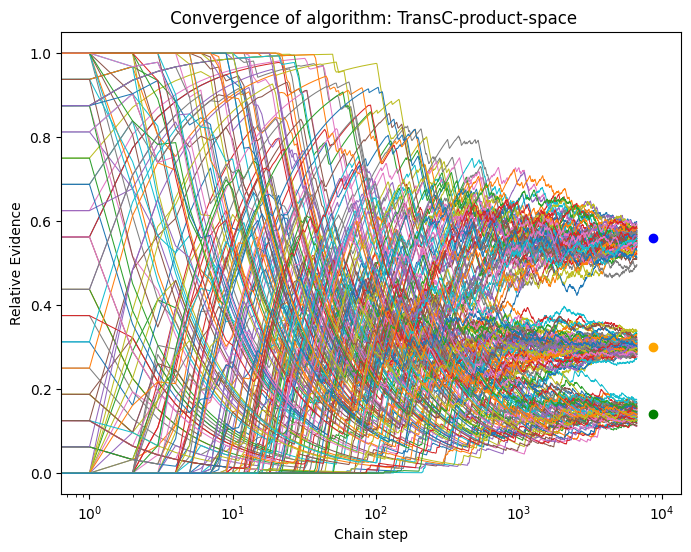

In [20]:
# plot relative number of visits to each state along the chain
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))

    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, trueML[0], "bo")
    plt.plot(len(visits) * 1.3, trueML[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, trueML[2], "go")
    plt.title(" Convergence of algorithm: " + alg)
    # plt.savefig('convergence_product_3-5-10.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains of the Product-space sampler are slowly 
converging, and visiting each state in proportion to the correct normalization constant. 

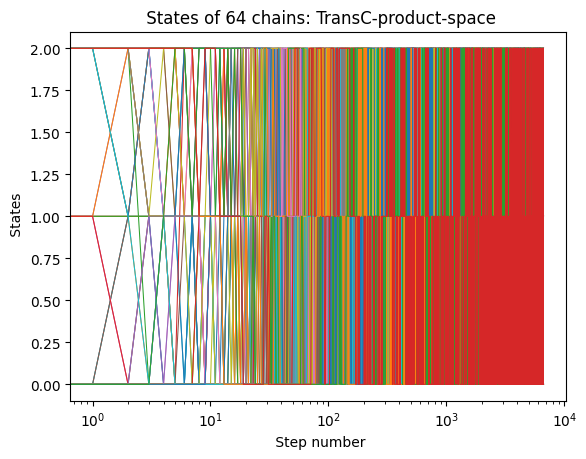

In [21]:
# plot movement of chains between states
if plotting:
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0], -1), lw=0.75)
    # plt.semilogx(state_chain.T,lw=0.75)
    plt.xlabel(" Step number")
    plt.ylabel(" States")
    title = " States of " + str(nwalkers_ps) + " chains: " + alg
    plt.title(title)
    # plt.savefig('convergence.pdf')
    plt.show()

This plot shows the movement of each chain between states.

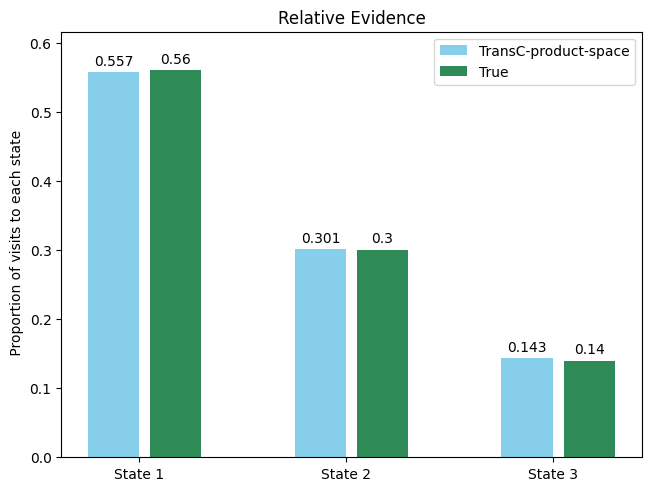

In [22]:
if plotting:
    # Count visits to each state by Trans-D mcmc
    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)

    # plot histogram of frequency of visits to each state

    labels = ("State 1", "State 2", "State 3")
    labels = ["State " + str(i + 1) for i in np.arange(nstates)]

    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")

    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(trueML, 3), width, label="True", color="seagreen"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    ax.set_ylim(0.0, np.max(np.maximum(h, trueML)) * 1.1)
    plt.show()

Recovery of the normalization constants is accurate.

 State;  0  in  3  dimensions
 State;  1  in  5  dimensions
 State;  2  in  10  dimensions


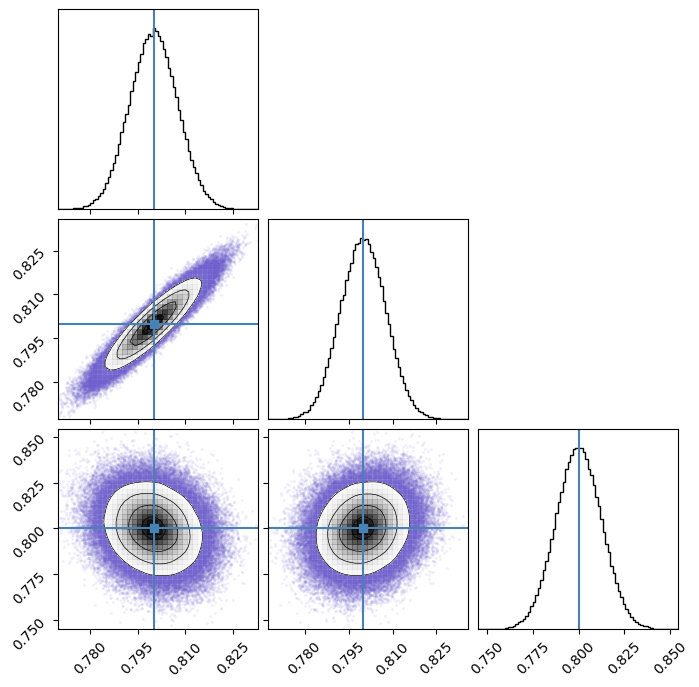

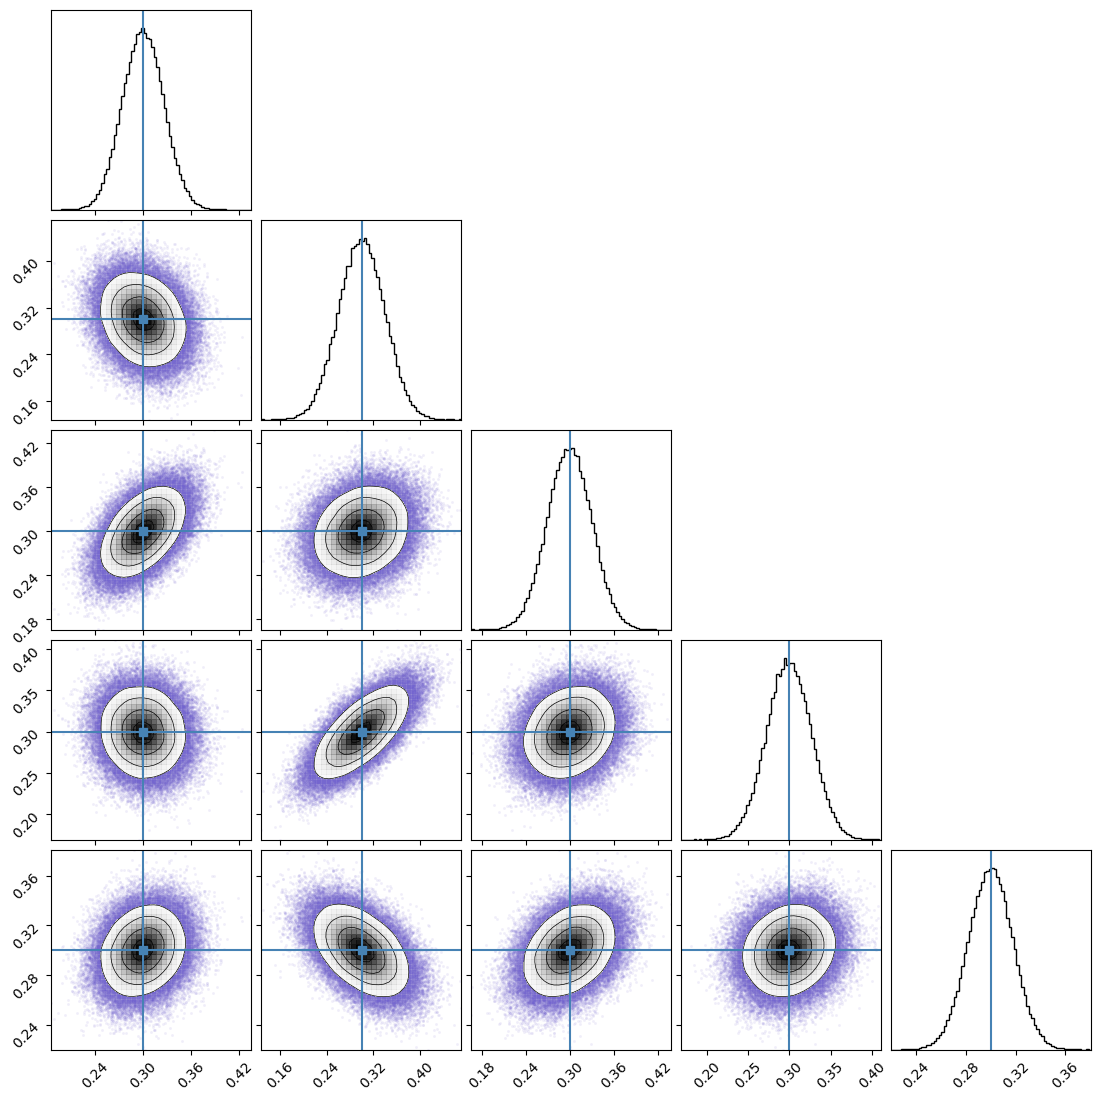

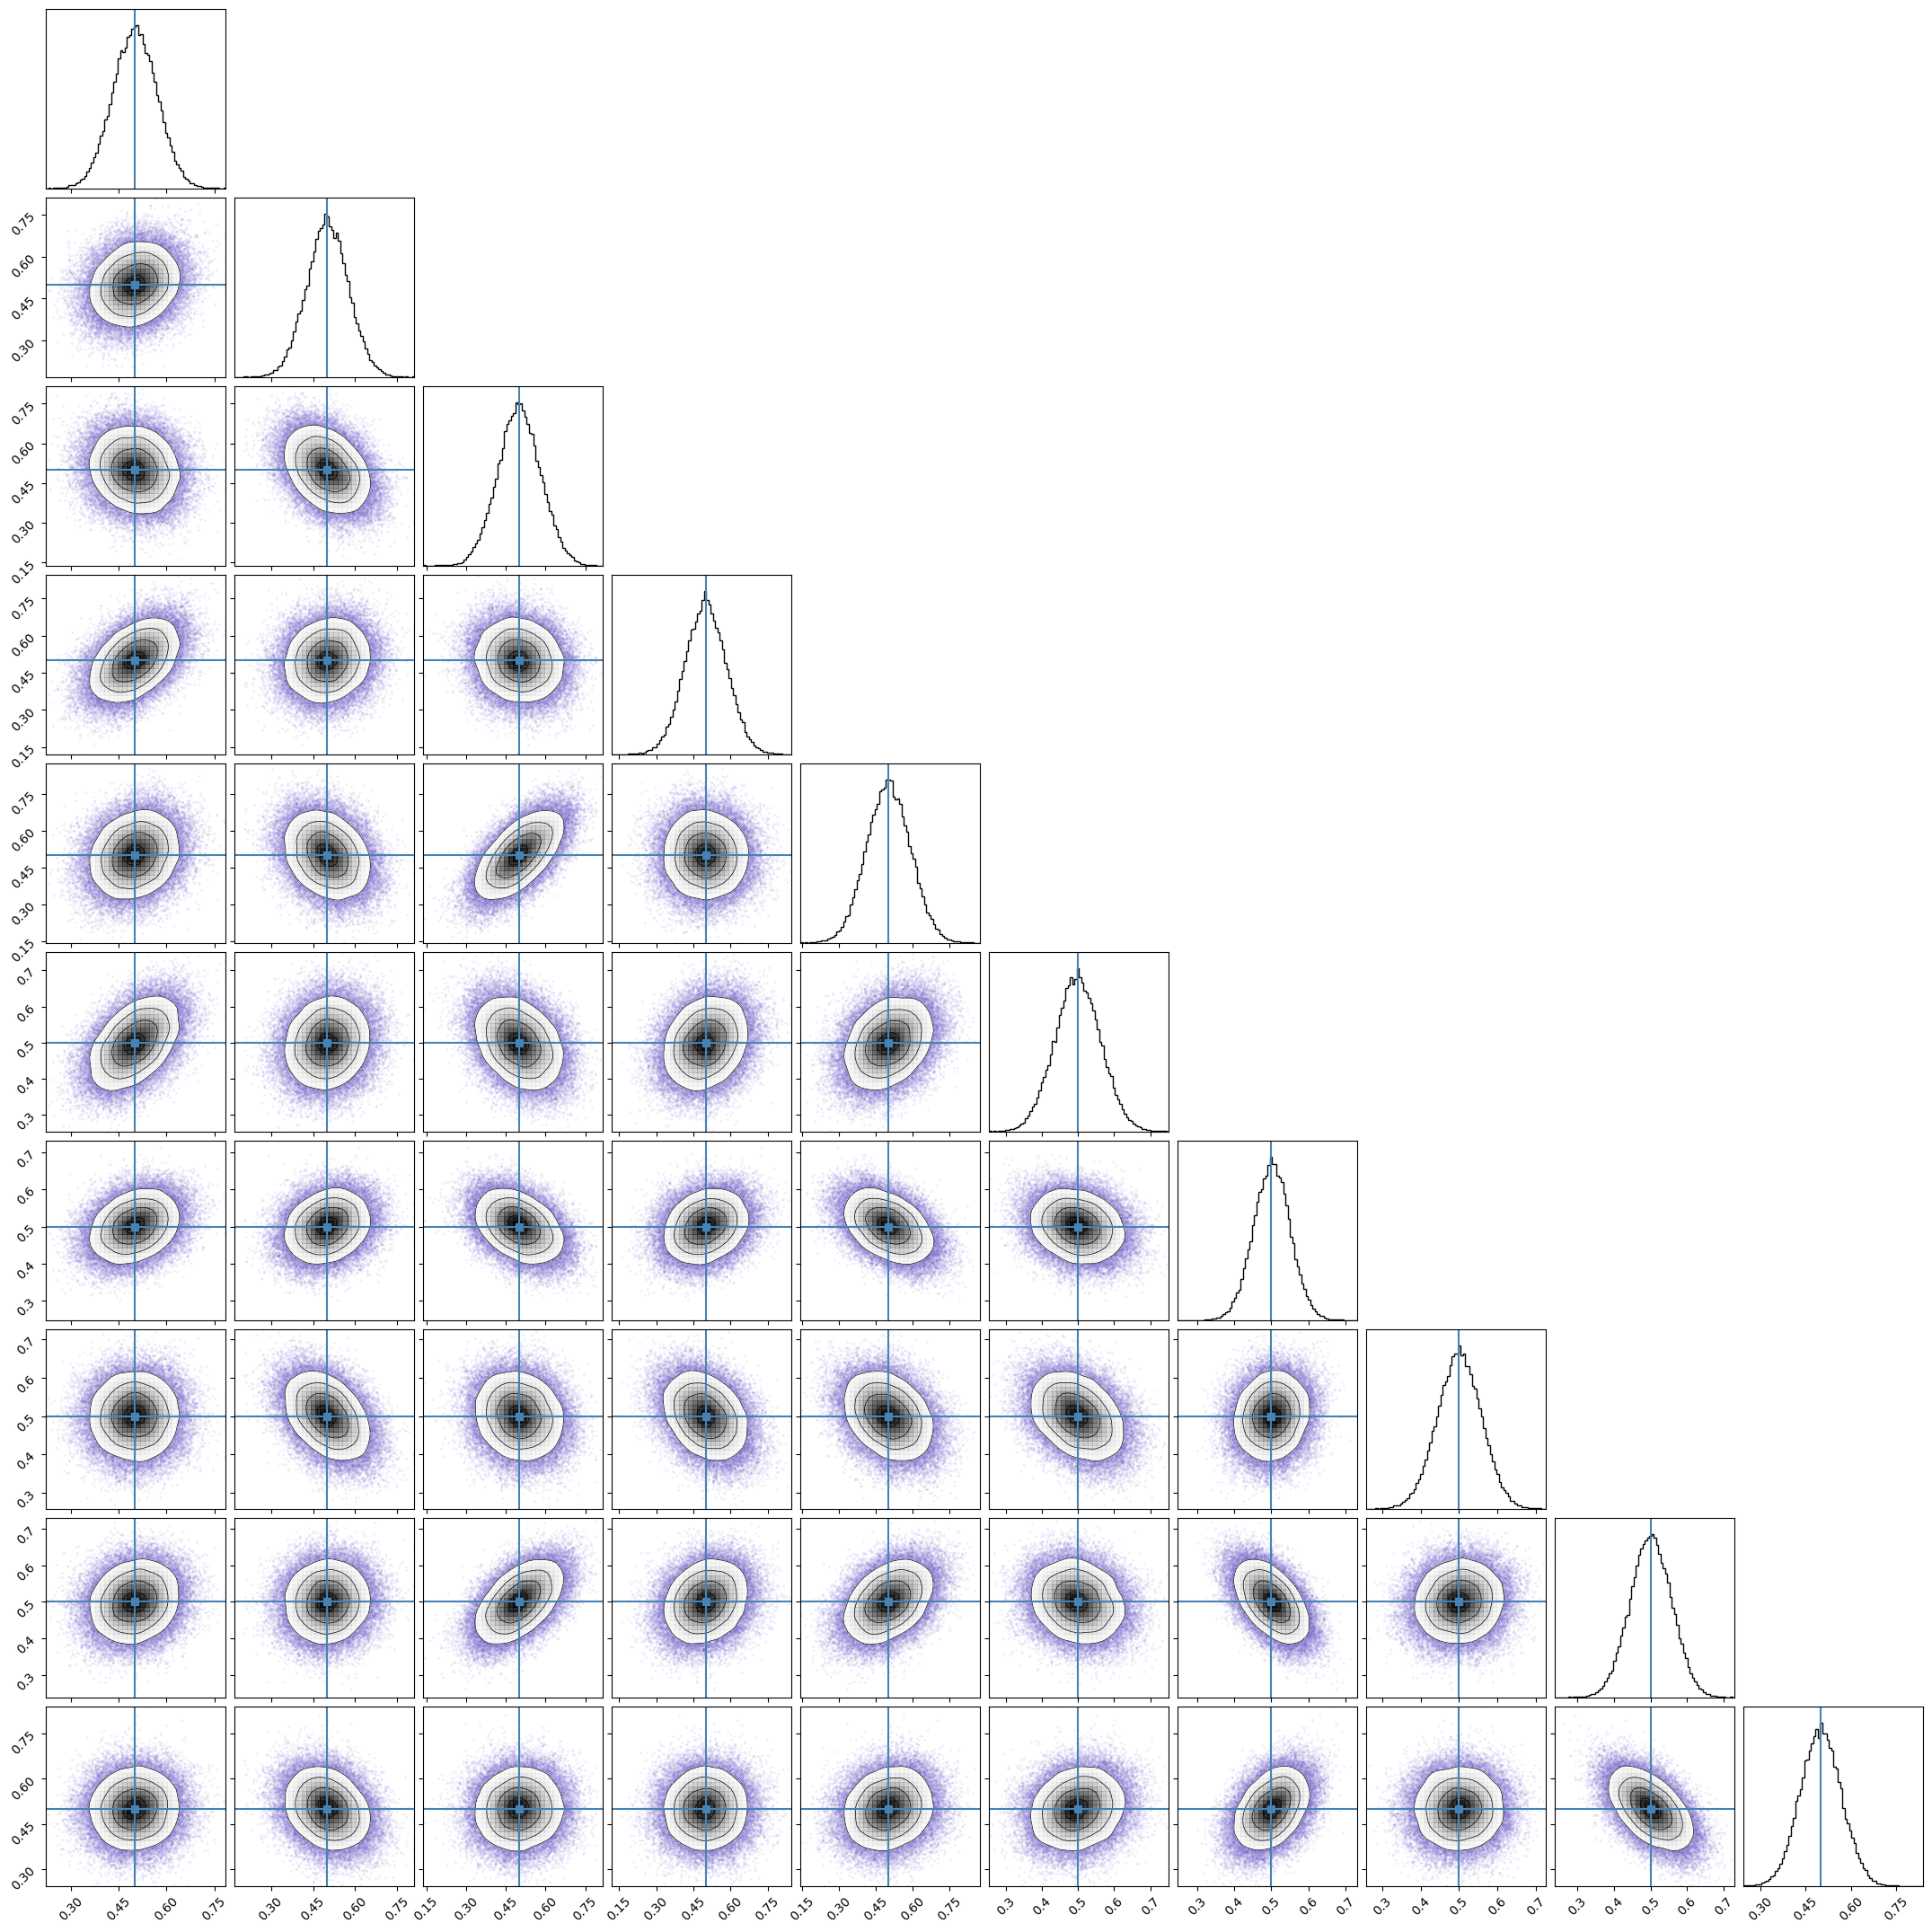

In [23]:
# corner plots to check sampling within each state
if plotting:
    # collect trans samples
    transc_ensemble = get_transc_samples(
        result,
        discard=0,
        thin=thin,
    )
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "darkblue"}
    data_kwargs = {"color": "slateblue"}
    for i in range(nstates):
        string = "State " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            flatten_extend(transc_ensemble[i]).reshape(-1, ndims[i]),
            truths=mu[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )

Density of within state samples looks reasonable.

In [24]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

 Here is the Trans-C ensemble with
 237550 samples in state 1
 128315 samples in state 2
 60823 samples in state 3
 
 [array([[0.79946665, 0.80155297, 0.79854858],
       [0.79938274, 0.80204907, 0.79814943],
       [0.79967074, 0.80139091, 0.79871967],
       ...,
       [0.79530728, 0.79737268, 0.80153077],
       [0.79349923, 0.7955502 , 0.79787376],
       [0.79284069, 0.79486553, 0.80073917]], shape=(237550, 3)), array([[0.29978136, 0.30009687, 0.30004483, 0.29998208, 0.29998628],
       [0.27305673, 0.3210454 , 0.26307754, 0.29782001, 0.27983698],
       [0.28778177, 0.3208851 , 0.27395203, 0.32131939, 0.29616345],
       ...,
       [0.3091691 , 0.30868943, 0.30194665, 0.34998053, 0.32661873],
       [0.31136546, 0.31063034, 0.30212544, 0.35030053, 0.32480213],
       [0.27393846, 0.37425883, 0.27448421, 0.37985537, 0.30114076]],
      shape=(128315, 5)), array([[0.56633305, 0.56620536, 0.4019384 , ..., 0.53823415, 0.39283062,
        0.59692762],
       [0.53614691, 0.53941189,